In [1]:
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 74750 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/samrfreitas/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
train_ds

len(train_ds)

train_ds[0]
{'label': 0, 'text': 'i didnt feel humiliated'}

{'label': 0, 'text': 'i didnt feel humiliated'}

In [5]:
train_ds.column_names

['text', 'label']

In [6]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [7]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


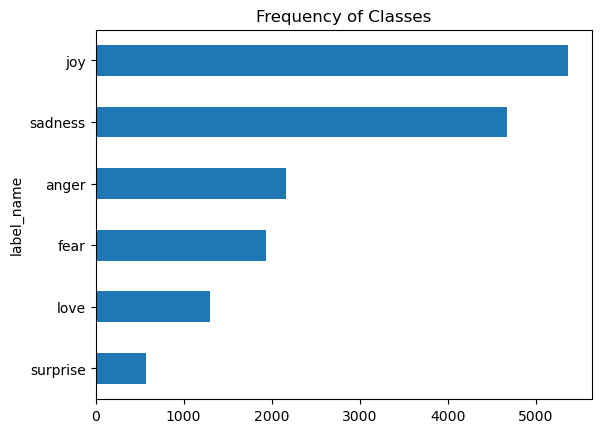

In [9]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

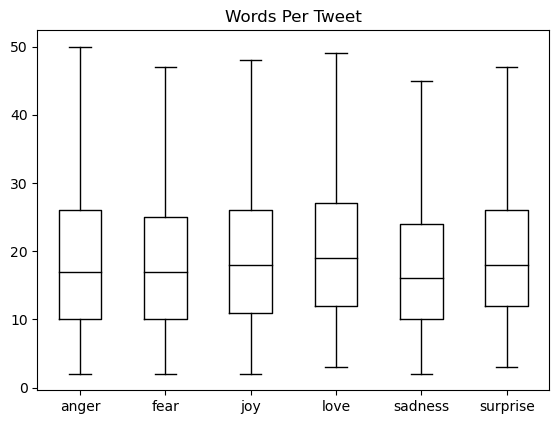

In [10]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [11]:
emotions.reset_format()

In [12]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
text = """"Tokenizing text is a
core task of NLP."""
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1000, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [14]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', '"', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [15]:
tokenizer.vocab_size

30522

In [16]:
tokenizer.model_max_length

512

In [17]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [19]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /Users/samrfreitas/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-731f069f44f7dba9.arrow
Loading cached processed dataset at /Users/samrfreitas/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-ba7efd7245b4c0ae.arrow
Loading cached processed dataset at /Users/samrfreitas/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-9b11da61b48b4023.arrow


In [20]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [21]:
from transformers import AutoModel
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [22]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [23]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [24]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [25]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [26]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [27]:
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])

In [28]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Loading cached processed dataset at /Users/samrfreitas/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-65649615e2675475.arrow
Loading cached processed dataset at /Users/samrfreitas/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-0b1742fbeeea2de7.arrow
Loading cached processed dataset at /Users/samrfreitas/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-fb54090ca3c88a24.arrow


In [29]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [30]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [31]:
pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [32]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.001544,6.041932,0
1,-3.242765,5.184499,0
2,5.065421,2.657511,3
3,-2.365932,3.186652,2
4,-3.486017,3.067207,3


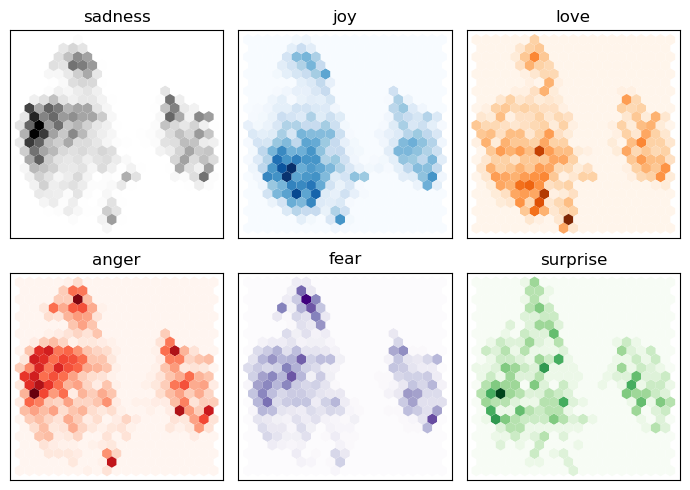

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
        gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [34]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [35]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

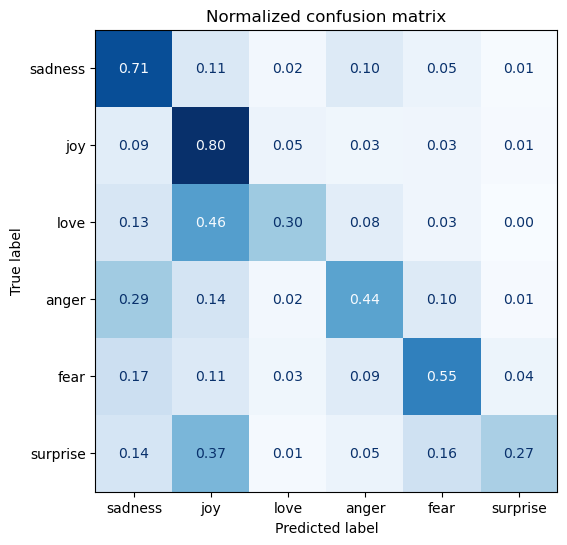

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [37]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [39]:
from huggingface_hub import notebook_login
notebook_login()

In [40]:
pip install accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [41]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=2,
                                    learning_rate=2e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    push_to_hub=True,
                                    log_level="error")

In [42]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=emotions_encoded["train"],
                    eval_dataset=emotions_encoded["validation"],
                    tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.832200,0.338376,0.903000,0.900861
2,0.252800,0.221917,0.924000,0.923856


TrainOutput(global_step=500, training_loss=0.5424683685302735, metrics={'train_runtime': 959.3695, 'train_samples_per_second': 33.355, 'train_steps_per_second': 0.521, 'total_flos': 720342861696000.0, 'train_loss': 0.5424683685302735, 'epoch': 2.0})

In [44]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.22191666066646576,
 'test_accuracy': 0.924,
 'test_f1': 0.9238559748877813,
 'test_runtime': 12.3877,
 'test_samples_per_second': 161.45,
 'test_steps_per_second': 2.583}

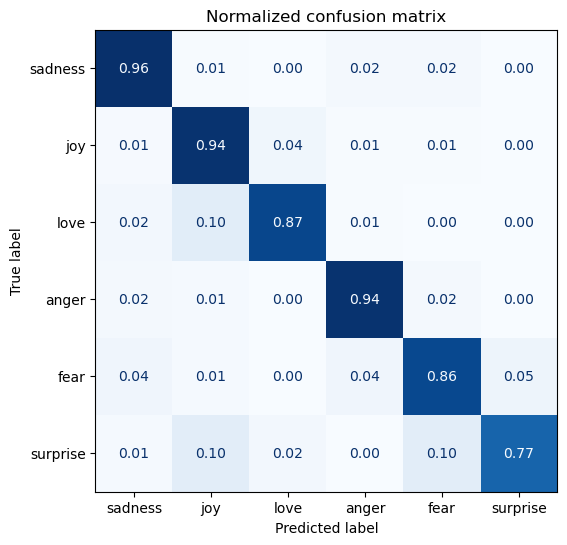

In [45]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

In [46]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
        reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
    "predicted_label": pred_label.cpu().numpy()}

### Esse código é necessário para trabalhar com M1 por não possuir uma GPU

In [59]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [61]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
forward_pass_with_label, batched=True, batch_size=16)

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
.apply(label_int2str))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [62]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.885129
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.713261
882,i feel badly about reneging on my commitment t...,love,sadness,5.609083
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.526821
1801,i feel that he was being overshadowed by the s...,love,sadness,5.475105
1963,i called myself pro life and voted for perry w...,joy,sadness,5.347246
1274,i am going to several holiday parties and i ca...,joy,sadness,5.280738
1195,i always think about are act the way i want to...,anger,joy,5.159596
1111,im lazy my characters fall into categories of ...,joy,fear,5.043490
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.841454


In [63]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.013170
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.013185
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.013362
733,i feel rotten and ive forgotten myself,sadness,sadness,0.013474
69,i have no extra money im worried all of the ti...,sadness,sadness,0.013626
352,i feel worthless confused edgy and mentally dr...,sadness,sadness,0.013719
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.013739
697,i was missing him desperately and feeling idio...,sadness,sadness,0.013774
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.013776
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.013799


In [64]:
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/samrfreitas/distilbert-base-uncased-finetuned-emotion/tree/main/'

In [65]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "samrfreitas/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

/Users/samrfreitas/anaconda3/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


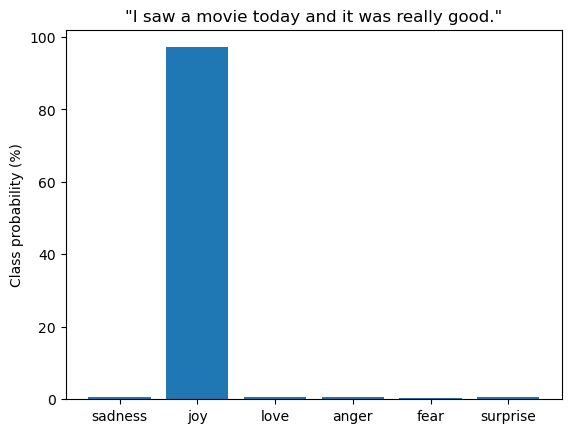

In [66]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()